### Table of Contents

1. [Setup and Data Loading](#1-setup-and-data-loading)  

2. [Descriptive Statistics](#2-descriptive-statistics)
    - [Table 1. Descriptive Statistics of Key Fiscal, Demographic, and Outcome Variables](#table-1-descriptive-statistics-of-key-fiscal-demographic-and-outcome-variables)
    - [Table 2. Averages of Fiscal, Outcome, and Demographic Indicators by Income Level](#table-2-averages-of-fiscal-outcome-and-demographic-indicators-by-income-level)
    - [Table 3. Regional Averages of Fiscal, Outcome, and Development Indicators](#table-3-regional-averages-of-fiscal-outcome-and-development-indicators)

3. [Demographic Structure and Public Spending Analysis](#3-demographic-structure-and-public-spending-analysis)
    - [Figure 1. Old-Age Dependency Ratio Projection of Selected Countries](#figure-1-old-age-dependency-ratio-projection-of-selected-countries)
    - [Figure 2. Demographic Shifts by Country (1960 - 2050)](#figure-2-demographic-shifts-by-country-1960---2050)
    - [Figure 3. Age Distribution Visualization for Selected Countries](#figure-3-age-distribution-visualization-for-selected-countries)
    - [Figure 4. Distribution of Health and Education Expenditure (% of GDP) by Income Level](#figure-4-distribution-of-health-and-education-expenditure--of-gdp-by-income-level)
    - [Figure 5. Public Health and Education Spending vs. Life Expectancy by Income Group](#figure-5-public-health-and-education-spending-vs-life-expectancy-by-income-group)

4. [Correlation and Regression Analysis](#4-correlation-and-regression-analysis)
    - [Table 4. Correlation Matrix of Public Spending, Outcomes, and Economic Indicators](#table-4-correlation-matrix-of-public-spending-outcomes-and-economic-indicators)
    - [Figure 6. Health Expenditure and Dependency Ratio (Old and Young) By Income](#figure-6-health-expenditure-and-dependency-ratio-old-and-young-by-income)
    - [Figure 7. Health Expenditure and Dependency Ratio (Old and Young) By Region](#figure-7-health-expenditure-and-dependency-ratio-old-and-young-by-region)
    - [Figure 8. Education Expenditure and Dependency Ratio (Old and Young) By Income](#figure-8-education-expenditure-and-dependency-ratio-old-and-young-by-income)
    - [Figure 9. Health Expenditure and Dependency Ratio (Old and Young) By Region](#figure-9-health-expenditure-and-dependency-ratio-old-and-young-by-region)
    - [Table 5. Regression of Health Expenditure on Old-Age Dependency Ratio (Summary)](#table-5-regression-of-health-expenditure-on-old-age-dependency-ratio-summary)
    - [Table 6. Regression of Education Expenditure on Young-Age Dependency Ratio (Summary)](#table-6-regression-of-education-expenditure-on-young-age-dependency-ratio-summary)

5. [Expenditure Projection Analysis](#5-health-expenditure-projections-to-2050) 
    - [Figure 10. GDP per Capita Projection by Country](#figure-10-gdp-per-capita-projection-by-country)
    - [Figure 11. Health Expenditure Projection by Country](#figure-11-health-expenditure-projection-by-country)
    - [Figure 12. Health Expenditure Projection for Selected Countries](#figure-12-health-expenditure-projection-for-selected-countries)

6. [Efficiency Index Analysis](#6-health-effeciency-index-analysis)


## 1. Setup and Data Loading

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import seaborn as sns

In [2]:
sys.path.append('../src/visualization')
from age_dist_visual import set_seaborn_style

In [3]:
#Import function for cleaning, merged, and import data from cleaning_data.py and Import_and_Cleaning.py
sys.path.append('../src/Import_and_Cleaning')
from import_and_merge_data import load_and_merge_all_data

df_main = load_and_merge_all_data()
df_main.to_csv('../data/interim/merged_data.csv', index=False)
df_main.head(2)

,Country,ISO3,Year,Health_Expenditure,Education_Expenditure,Dependency_Ratio,Dependency_Ratio_Old,Dependency_Ratio_Young,Life_Expectancy,Mortality_Rate,average_schooling,learning_scores,GDP_percapita,trade_gdp,gov_consumption_gdp,Population,income_level,Region
0,Argentina,ARG,2000,8.220011,4.58031,60.839942,15.536781,45.303162,73.910,16.7,8.802,NaN,7637.014892,22.622445,13.784191,37213984.0,Upper middle income,Latin America & Caribbean
1,Argentina,ARG,2001,8.371799,4.83374,60.442089,15.603500,44.838589,74.154,16.2,8.870,NaN,7141.475077,21.852255,14.156274,37624825.0,Upper middle income,Latin America & Caribbean


This is our main dataset, consists of 17 columns:
1. Country
2. ISO Code
3. Health Expenditure (% of GDP)
4. Education Expenditure (% of GDP)
5. Dependency Ratio (% of working-age population)
6. Dependency Ratio Old (older than 64, % of working-age population)
7. Dependency Ratio Young (younger than 15, % of working-age population)
8. Life Expectancy (years)
9. Mortality Rate (per1000 live births)
10. Average Year Schooling (years)
11. Learning Outcomes (score)
12. GDP per capita (USD)
13. Trade to GDP (% of GDP)
14. Government consumption to GDP (% of GDP)
15. Population
16. Income Level Category
17. Region

## 2. Descriptive Statistics

###### **Table 1. Descriptive Statistics of Key Fiscal, Demographic, and Outcome Variables**

In [17]:
pd.set_option('display.float_format', '{:.2f}'.format)
desc = df_main.drop(columns=['Year','Population']).describe().T.round(2)
desc.index = desc.index.str.replace('_', ' ')
desc = desc.rename(columns={'25%': '25', '50%': '50', '75%': '75'})
desc.to_csv("../overleaf/Tabel 1 Descriptive Statistic.csv")
desc

,count,mean,std,min,25,50,75,max
Health Expenditure,1264.00,6.45,2.76,1.77,4.38,5.95,8.25,18.81
Education Expenditure,1052.00,4.19,1.32,0.35,3.30,4.14,5.18,7.66
Dependency Ratio,2805.00,55.05,10.75,26.87,47.78,53.19,60.24,101.75
Dependency Ratio Old,2805.00,20.54,13.08,3.85,9.47,17.64,28.73,75.61
Dependency Ratio Young,2805.00,34.51,14.90,12.07,23.63,29.61,42.20,96.48
Life Expectancy,1265.00,73.44,6.54,47.14,69.82,74.09,78.28,84.56
Mortality Rate,1265.00,18.44,18.09,1.80,5.20,13.20,23.60,97.10
average schooling,1260.00,9.37,2.82,1.48,7.44,10.00,11.46,14.30
learning scores,204.00,455.70,62.02,309.02,408.96,444.38,516.79,581.00
GDP percapita,1265.00,14000.89,17657.07,109.59,2035.17,5477.04,19695.73,106194.76


This table provides a summary of key variables across all countries and years in the dataset. On average, countries spend 6.45% of GDP on health and 4.19% on education, with substantial variation between them (e.g., health spending ranges from 1.77% to 18.81%).

The dependency burden also varies widely.  Overall dependency (young + old) averages 55.05% of the working‐age population, but ranges from 26.87% to 101.75%.  Breaking this down, the old‐age dependency ratio averages 20.54% (min 3.85%, max 75.61%), while the youth dependency ratio averages 34.51% (min 12.07%, max 96.48%).  These differences reflect how demographic structure—and the share of non‐working dependents—differs dramatically across countries and over time.

GDP per capita ranges from just \$110 to over \$106 000, highlighting the diverse economic landscape. Trade openness is high on average (81.20% of GDP), with some small economies reaching extreme levels (437.33%). Government consumption averages 15.06% of GDP.

###### **Table 2. Averages of Fiscal, Outcome, and Demographic Indicators by Income Level**

In [19]:
df_main.groupby('income_level')[['Health_Expenditure', 'Education_Expenditure', 'Life_Expectancy', 'Mortality_Rate', 'average_schooling', 'learning_scores', 'GDP_percapita', 'trade_gdp', 'gov_consumption_gdp']].mean().reindex(['Low income', 'Lower middle income', 'Upper middle income', 'High income']).T.round(2)

AverageByIncome = df_main.groupby('income_level')[
    ['Health_Expenditure', 'Education_Expenditure', 'Life_Expectancy',
     'Mortality_Rate', 'average_schooling', 'learning_scores',
     'GDP_percapita', 'trade_gdp', 'gov_consumption_gdp']
].mean().reindex(
    ['Low income', 'Lower middle income', 'Upper middle income', 'High income']
).T.round(2)

AverageByIncome.index = AverageByIncome.index.str.replace('_', ' ')

AverageByIncome.to_csv("../overleaf/Tabel 2 Average Fiscal Outcome by Income.csv")

AverageByIncome


income_level,Low income,Lower middle income,Upper middle income,High income
Health Expenditure,4.13,4.99,5.73,8.41
Education Expenditure,4.72,3.79,4.04,4.55
Life Expectancy,59.67,68.34,72.84,78.97
Mortality Rate,59.77,33.92,16.36,4.98
average schooling,2.11,7.51,8.82,11.76
learning scores,355.52,402.54,436.84,511.99
GDP percapita,456.41,2043.48,5674.55,31919.30
trade gdp,34.71,74.43,71.57,95.66
gov consumption gdp,9.40,12.96,13.90,17.82


This table highlights clear disparities across income groups. High-income countries spend the most on both health (8.41%) and education (4.55%) as a share of GDP, and have the best outcomes: life expectancy (78.8 years), lowest child mortality (4.98 per 1,000), and the highest average schooling (11.76 years) and learning scores (512).

In contrast, low-income countries spend less on health (4.13%), and though they slightly outspend on education (4.72%), they show the worst human development outcomes: life expectancy of 59.7 years, mortality rate of 59.8, and average schooling of only 2.1 years. Their GDP per capita is extremely low (≈$456), with limited government consumption (9.4%) and trade openness (34.7%).

Lower- and upper-middle income countries fall in between. Interestingly, lower-middle income countries have higher trade-to-GDP ratios than upper-middle income countries but lower government consumption shares. Upper-middle income countries, while closer to high-income nations in life expectancy and schooling, still lag significantly in per capita income.

These patterns underscore the importance of resource availability, but also raise questions about spending efficiency—particularly why similar spending levels in education across groups result in vastly different learning outcomes.

###### **Table 3. Regional Averages of Fiscal, Outcome, and Development Indicators**

In [20]:
df_main.groupby('Region')[['Health_Expenditure', 'Education_Expenditure', 'Life_Expectancy', 'Mortality_Rate', 'average_schooling', 'learning_scores', 'GDP_percapita', 'trade_gdp', 'gov_consumption_gdp']].mean().T.round(2)

AverageByRegion = df_main.groupby('Region')[['Health_Expenditure', 'Education_Expenditure', 'Life_Expectancy', 'Mortality_Rate', 'average_schooling', 'learning_scores', 'GDP_percapita', 'trade_gdp', 'gov_consumption_gdp']].mean().T.round(2)

AverageByRegion.index = AverageByRegion.index.str.replace('_', ' ')

AverageByRegion.to_csv("../overleaf/Tabel 3 Average Fiscal Outcome by Region.csv")

AverageByRegion

Region,East Asia & Pacific,Europe & Central Asia,Latin America & Caribbean,Middle East & North Africa,North America,South Asia,Sub-Saharan Africa
Health Expenditure,5.25,7.28,7.14,6.21,12.97,2.77,4.12
Education Expenditure,3.91,4.51,4.18,4.17,5.42,2.61,3.92
Life Expectancy,75.00,75.14,74.10,73.26,79.45,66.69,57.02
Mortality Rate,14.98,11.15,15.95,19.91,5.55,51.03,60.07
average schooling,9.42,11.26,8.28,7.89,13.31,5.08,4.99
learning scores,484.55,488.84,418.32,397.95,527.81,363.77,379.66
GDP percapita,17094.45,18844.86,7248.41,3807.27,47341.93,1175.92,1159.30
trade gdp,106.94,93.46,54.91,74.31,46.77,35.67,42.71
gov consumption gdp,13.94,17.51,13.22,15.16,17.68,8.85,12.37


This table presents regional averages and reveals stark contrasts in public spending, socioeconomic outcomes, and efficiency potential.

North America shows the highest investment in both health (12.97%) and education (5.42%), along with leading outcomes such as life expectancy (79.45 years), low mortality (5.55), and top learning scores (527.8). Europe & Central Asia and East Asia & Pacific also perform relatively well, with decent spending levels and strong average schooling and learning scores.

Latin America & the Caribbean maintains moderate spending levels and outcomes, but lower learning scores (418.3) despite relatively high education investment (4.18% of GDP), pointing to possible inefficiencies.

In contrast, South Asia and Sub-Saharan Africa face substantial challenges. Despite having very low GDP per capita (around $1,100), they also allocate the least to health and education and suffer from low life expectancy, high child mortality, and learning outcomes below 380. These regions may benefit most from improved spending efficiency and structural reforms.

Middle East & North Africa sits between these extremes, with slightly below-average spending but decent life expectancy and moderate learning outcomes.

Notably, trade openness is highest in East Asia & Pacific (106.9%) and Europe & Central Asia (95.3%), while government consumption varies regionally, with the highest shares in North America and Europe, and the lowest in South Asia.



## 3. Demographic Structure and Public Spending Analysis

### Demographic Structure Analysis

###### **Figure 1. Old-Age Dependency Ratio Projection of Selected Countries**

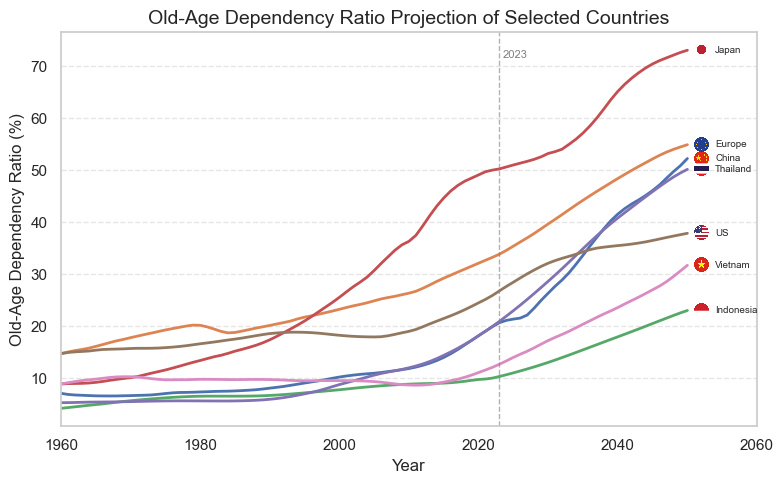

In [7]:
sys.path.append('../src/Import_and_Cleaning')
from setup_data_delta import get_selected_dependency_data #Call the graph data preparation function
sys.path.append('../src/visualization')
from ratio_lines import plot_dependency_ratio_lines #Call the graph visualization function

df_selected = get_selected_dependency_data()
plot_dependency_ratio_lines(df_selected)


It clearly shows a global trend toward aging societies, especially after the 2000s, where the proportion of elderly individuals relative to the working-age population begins to rise. Japan stands out as the most extreme case—by 2050, its old-age dependency ratio is projected to exceed 70%, meaning there will be more than 70 elderly individuals for every 100 working-age people. This highlights the urgent challenges many nations will face in supporting aging populations sustainable spending.

###### **Figure 2. Demographic Shifts by Country (1960 - 2050)**

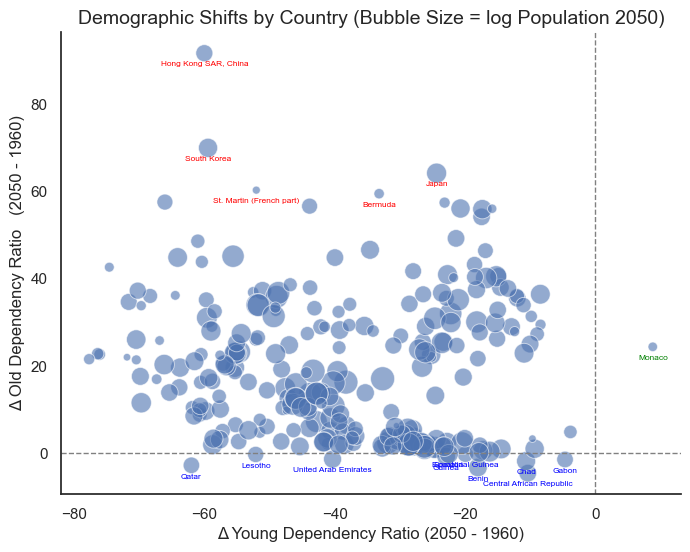

In [8]:
sys.path.append('../src/Import_and_Cleaning')
from setup_data_delta import prepare_change_df #Call the graph data preparation function
sys.path.append('../src/visualization')
from visual_bubble import plot_dependency_bubbles #Call the graph visualization function

change_df = prepare_change_df()
plot_dependency_bubbles(change_df)

This scatter plot highlights global demographic shifts between 1960 and 2050. Most countries are projected to move into the upper-left quadrant—marked by an increase in old-age dependency and a decrease in young-age dependency—indicating growing pressure on the working-age population. Examples include Hong Kong, South Korea, and Japan.

Only a few countries, like Qatar, the UAE, and Gabon, fall in the bottom-left quadrant, where both old and young dependency ratios are declining—suggesting a more favorable demographic structure with a relatively larger working-age population.

###### **Figure 3. Age Distribution Visualization for Selected Countries**

In [9]:
sys.path.append('../src/visualization')
from age_dist_visual import set_seaborn_style, create_age_distribution, format_ticks, add_legend, create_image_from_figure, add_padding_to_chart, generate_country_figure, create_grid

population_ratio_female = pd.read_csv("../data/raw/secondary/population_ratio_female.csv", index_col=None)
population_ratio_male = pd.read_csv("../data/raw/secondary/population_ratio_male.csv", index_col=None)

# Set styles
font_family = "PT Mono"
background_color = "#253D5B"
grid_color = "#355882"
text_color = "#EEEEEE"
set_seaborn_style(font_family, background_color, grid_color, text_color)

AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

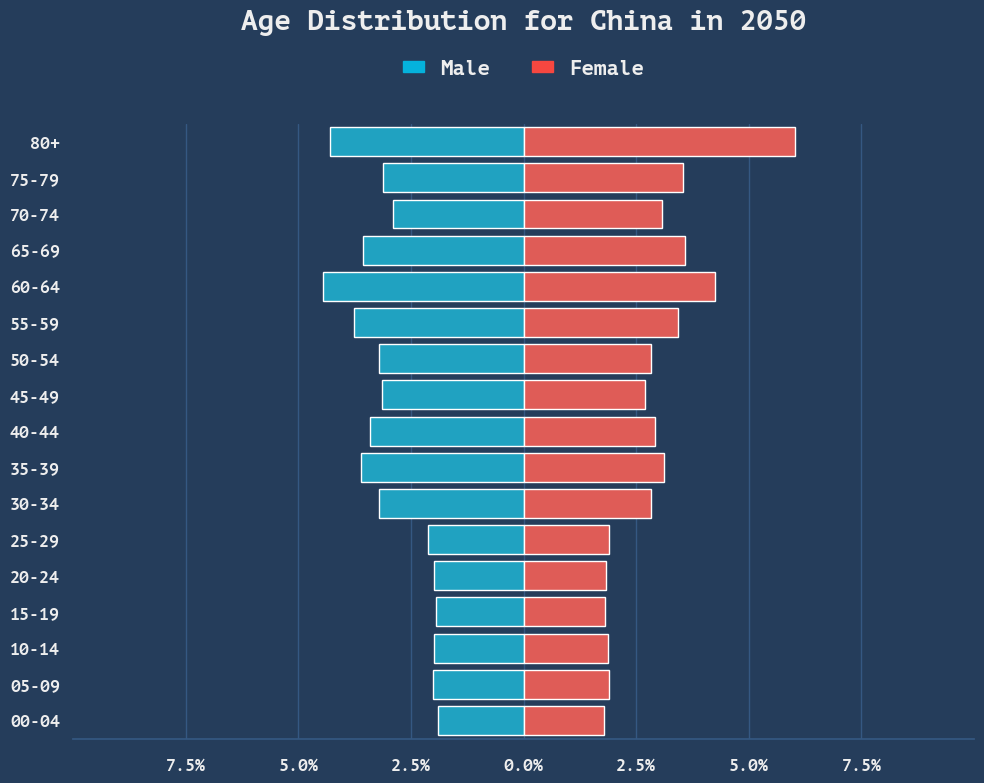

In [10]:
country_codes = ['CHN', 'USA', 'JPN', 'MNG'] 
year = "2050"

# Generate figures
figures = []
for code in country_codes:
    country_name = population_ratio_female[population_ratio_female.country_code == code]["country_name"].iloc[0]
    image = generate_country_figure(
        female_df=population_ratio_female,
        male_df=population_ratio_male,
        country_code=code,
        year=year,
        background_color=background_color
    )
    figures.append(image)

# Display grid
grid = create_grid(figures, pad=20, ncols=4)
grid

These shows the typical shape of aging societies: a bulging top, especially in the 80+ age group. Women dominate these oldest age brackets, reflecting their longer life expectancy. This skewed age distribution is most pronounced in countries like Japan and South Korea, where the base (younger population) is much narrower than the top, signaling major demographic and social challenges ahead.

### Public Spending Analysis

###### **Figure 4. Distribution of Health and Education Expenditure (% of GDP) by Income Level**

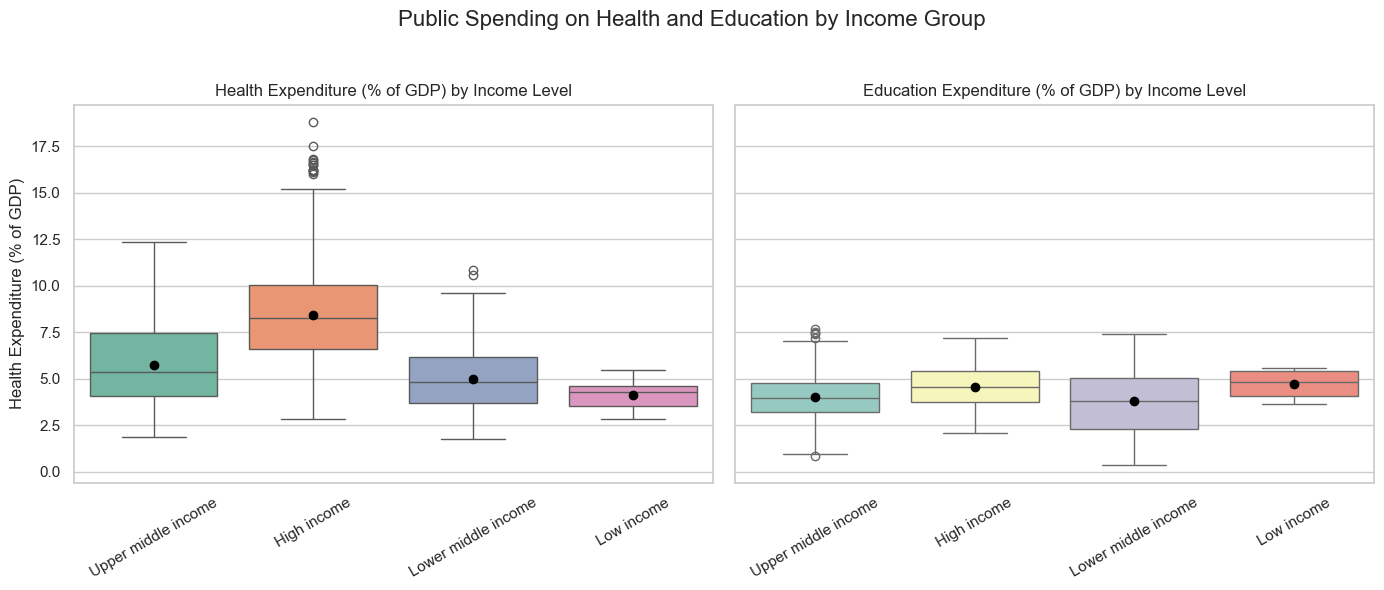

In [21]:
# Set a cleaner style
sns.set(style="whitegrid", palette="pastel")

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Boxplot for Health Expenditure ---
sns.boxplot(
    data=df_main,
    x='income_level',
    y='Health_Expenditure',
    hue='income_level',  # Fix for future warning
    palette='Set2',
    ax=axes[0],
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"},
    legend=False
)
axes[0].set_title("Health Expenditure (% of GDP) by Income Level")
axes[0].set_xlabel("")
axes[0].set_ylabel("Health Expenditure (% of GDP)")
axes[0].tick_params(axis='x', rotation=30)

# --- Boxplot for Education Expenditure ---
sns.boxplot(
    data=df_main,
    x='income_level',
    y='Education_Expenditure',
    hue='income_level',
    palette='Set3',
    ax=axes[1],
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"},
    legend=False
)
axes[1].set_title("Education Expenditure (% of GDP) by Income Level")
axes[1].set_xlabel("")
axes[1].set_ylabel("")  # Avoid repeating label
axes[1].tick_params(axis='x', rotation=30)

# Adjust layout
plt.suptitle("Public Spending on Health and Education by Income Group", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

This figure compares the distribution of government spending on health and education across income groups.

High-income countries allocate the highest share to health, with a median above 8%, and a wider range including several outliers exceeding 15–17%. Upper-middle income countries follow, though with greater spread and lower central tendency.
Lower-middle and low-income countries exhibit both lower medians and narrower spreads, indicating more consistent but constrained health budgets.

In education, the patterns are somewhat different:

Low-income countries appear to prioritize education slightly more in relative terms compared to their health spending, showing a median close to 5%, comparable to upper-middle income groups. However, high-income countries remain consistently strong in education investment too, with less variability and relatively high means.

The black dots overlaying the boxes represent mean values, offering a fuller picture alongside the median line. Overall, the plots visually reinforce fiscal inequality across income groups and hint at varying fiscal priorities—crucial for understanding spending efficiency.

###### **Figure 5. Public Spending vs Outcomes by Income Level**

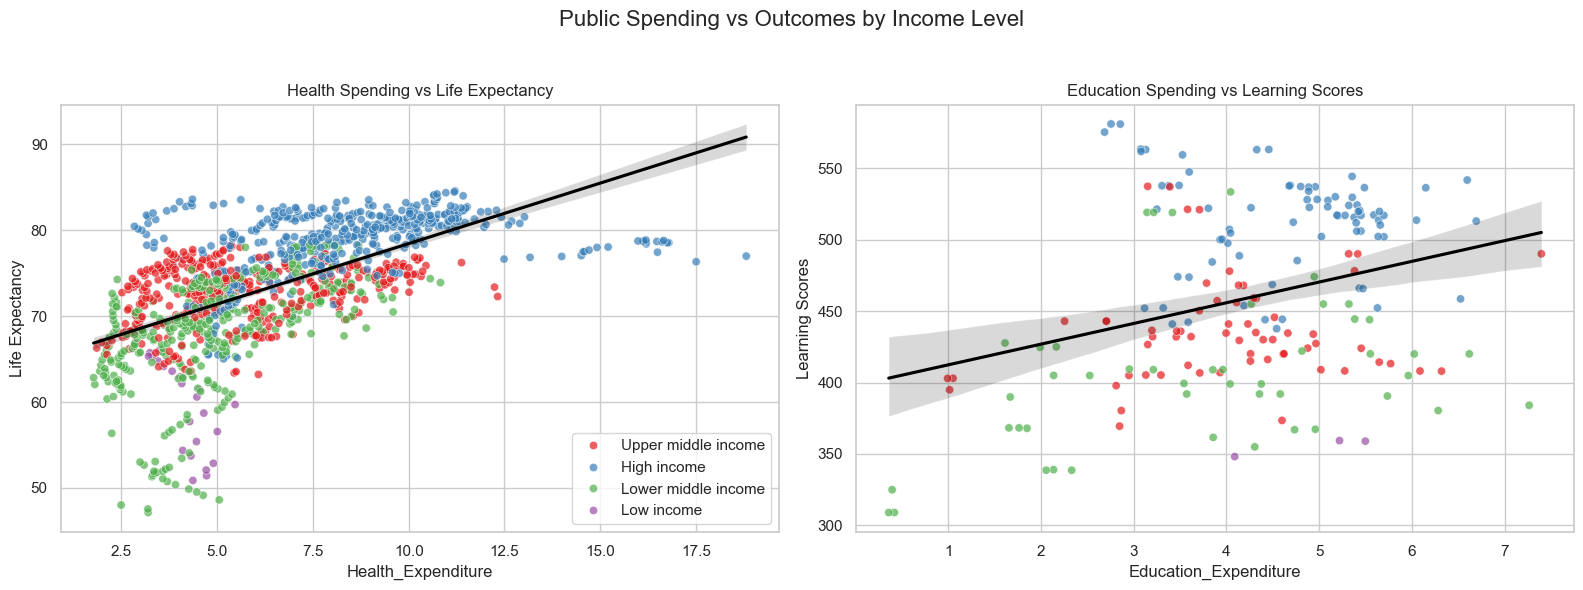

In [22]:
# Set style
sns.set(style="whitegrid")

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)  # sharey=False since y-axes are now different

# Plot 1: Health Expenditure vs Life Expectancy
sns.scatterplot(
    data=df_main,
    x="Health_Expenditure",
    y="Life_Expectancy",
    hue="income_level",
    ax=axes[0],
    palette="Set1",
    alpha=0.7
)
sns.regplot(
    data=df_main,
    x="Health_Expenditure",
    y="Life_Expectancy",
    scatter=False,
    ax=axes[0],
    color="black",
    line_kws={"label": "Linear trend"}
)
axes[0].set_title("Health Spending vs Life Expectancy")
axes[0].legend(loc="lower right")
axes[0].set_ylabel("Life Expectancy")

# Plot 2: Education Expenditure vs Learning Scores
sns.scatterplot(
    data=df_main,
    x="Education_Expenditure",
    y="learning_scores",  # Correct column name
    hue="income_level",
    ax=axes[1],
    palette="Set1",
    alpha=0.7,
    legend=False
)
sns.regplot(
    data=df_main,
    x="Education_Expenditure",
    y="learning_scores",  # Correct column name
    scatter=False,
    ax=axes[1],
    color="black",
    line_kws={"label": "Linear trend"}
)
axes[1].set_title("Education Spending vs Learning Scores")
axes[1].set_ylabel("Learning Scores")

# Improve layout
plt.suptitle("Public Spending vs Outcomes by Income Level", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


This figure compares the relationship between health spending and life expectancy (left) and education spending and learning scores (right) across countries by income level. A global regression line (black) highlights overall trends.

Health spending shows a stronger and steeper positive correlation with life expectancy, especially among high- and upper-middle-income countries, which cluster in the top-right. In contrast, the link between education spending and learning outcomes is weaker and more variable, suggesting that factors beyond funding—like system quality—matter more.

Some lower-income countries achieve relatively high outcomes with modest spending, pointing to potentially efficient systems worth deeper analysis.

## 4. Correlation and Regression Analysis

### Correlation Analysis

###### **Table 4. Correlation Matrix of Public Spending, Outcomes, and Economic Indicators**

In [29]:
df_main[['Health_Expenditure', 'Education_Expenditure','Life_Expectancy', 'Mortality_Rate', 'average_schooling', 'learning_scores', 'trade_gdp', 'gov_consumption_gdp', 'GDP_percapita']].corr()
CorrelationMatrix = df_main[['Health_Expenditure', 'Education_Expenditure','Life_Expectancy', 'Mortality_Rate', 'average_schooling', 'learning_scores', 'trade_gdp', 'gov_consumption_gdp', 'GDP_percapita']].corr()

def format_for_latex(label):
    return label.replace('_', ' ', 1).replace(' ', r'\\', 1)  
CorrelationMatrix.index = CorrelationMatrix.index.map(format_for_latex)
CorrelationMatrix.columns = CorrelationMatrix.columns.map(format_for_latex)
CorrelationMatrix.to_csv("../overleaf/Tabel 4 Correlation Matrix.csv")

CorrelationMatrix

,Health\\Expenditure,Education\\Expenditure,Life\\Expectancy,Mortality\\Rate,average\\schooling,learning\\scores,trade\\gdp,gov\\consumption_gdp,GDP\\percapita
Health\\Expenditure,1.00,0.43,0.59,-0.54,0.61,0.49,-0.13,0.63,0.62
Education\\Expenditure,0.43,1.00,0.32,-0.37,0.30,0.31,-0.01,0.54,0.28
Life\\Expectancy,0.59,0.32,1.00,-0.89,0.66,0.72,0.25,0.49,0.68
Mortality\\Rate,-0.54,-0.37,-0.89,1.00,-0.74,-0.72,-0.28,-0.50,-0.53
average\\schooling,0.61,0.30,0.66,-0.74,1.00,0.75,0.21,0.50,0.62
learning\\scores,0.49,0.31,0.72,-0.72,0.75,1.00,0.42,0.44,0.74
trade\\gdp,-0.13,-0.01,0.25,-0.28,0.21,0.42,1.00,0.00,0.27
gov\\consumption_gdp,0.63,0.54,0.49,-0.50,0.50,0.44,0.00,1.00,0.43
GDP\\percapita,0.62,0.28,0.68,-0.53,0.62,0.74,0.27,0.43,1.00


Health expenditure is positively correlated with life expectancy (0.58), GDP per capita (0.60), and government consumption (0.60), suggesting that wealthier countries with higher public spending tend to achieve better health outcomes. Learning scores are strongly related to average schooling (0.75), GDP per capita (0.74), and life expectancy (0.72), emphasizing the compound benefits of both health and education investment.

Government consumption correlates well with education spending (0.53) and health spending (0.60), showing that fiscal expansion is a key driver of social investments.

Mortality rate shows a strong negative correlation with life expectancy (-0.89), as expected, and is also negatively related to schooling (-0.73) and learning scores (-0.72) — confirming that lower health outcomes often go hand-in-hand with weaker educational attainment. Mortality is also negatively associated with GDP per capita (-0.53) and public spending, reinforcing the developmental gap in lower-income countries.

GDP per capita shows strong positive links with nearly every development indicator: life expectancy (0.67), learning (0.74), schooling (0.62), and public health and education spending, emphasizing that higher income levels enable and often result from better social outcomes.

#### Health Expenditure vs Dependency Ratio

###### **Figure 6. Health Expenditure and Dependency Ratio (Old and Young) By Income**

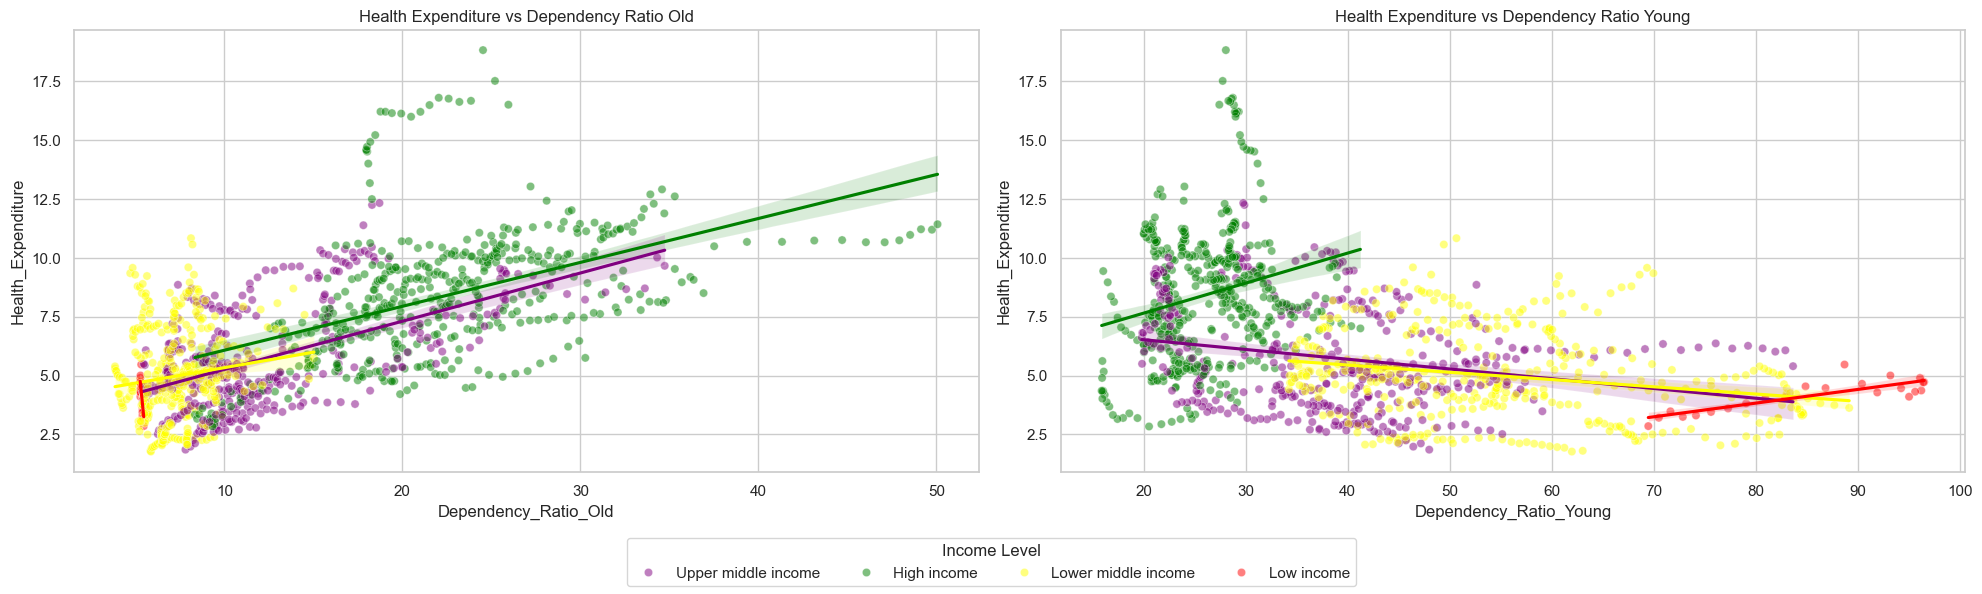

In [30]:
df = pd.read_csv("../data/interim/merged_data.csv")

# Define custom color palette
palette = {
    "High income": "green",
    "Upper middle income": "purple",
    "Lower middle income": "yellow",
    "Low income": "red"
}

# Set up the plot style
#sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Health Expenditure vs Dependency_Ratio_Old
sns.scatterplot(data=df, x="Dependency_Ratio_Old", y="Health_Expenditure", hue="income_level", palette=palette, alpha=0.5, ax=axes[0])
for income, color in palette.items():
    sub_df = df[df["income_level"] == income]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Old", y="Health_Expenditure", scatter=False, color=color, ax=axes[0])
axes[0].set_title("Health Expenditure vs Dependency Ratio Old")

# Plot 2: Health Expenditure vs Dependency_Ratio_Young
sns.scatterplot(data=df, x="Dependency_Ratio_Young", y="Health_Expenditure", hue="income_level", palette=palette, alpha=0.5, ax=axes[1])
for income, color in palette.items():
    sub_df = df[df["income_level"] == income]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Young", y="Health_Expenditure", scatter=False, color=color, ax=axes[1])
axes[1].set_title("Health Expenditure vs Dependency Ratio Young")

# Adjust legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Income Level", loc='lower center', ncol=4)
for ax in axes:
    ax.legend_.remove()

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.subplots_adjust(bottom=0.2)
plt.show()

The left graph shows a clear positive correlation between old-age dependency ratio and health expenditure (% of GDP), especially in high-income and upper-middle-income countries. As populations age, healthcare demands tend to rise, and this is reflected in increased spending. Despite some outliers, the trend is consistent across income levels.

In contrast, the right graph—plotting health expenditure against young-age dependency ratio—shows a much weaker and more inconsistent relationship. The trend lines differ by income group, and there’s no clear global pattern. This suggests that the burden of young dependents does not drive health spending as strongly or uniformly as aging populations do.

###### **Figure 7. Health Expenditure and Dependency Ratio (Old and Young) By Region**

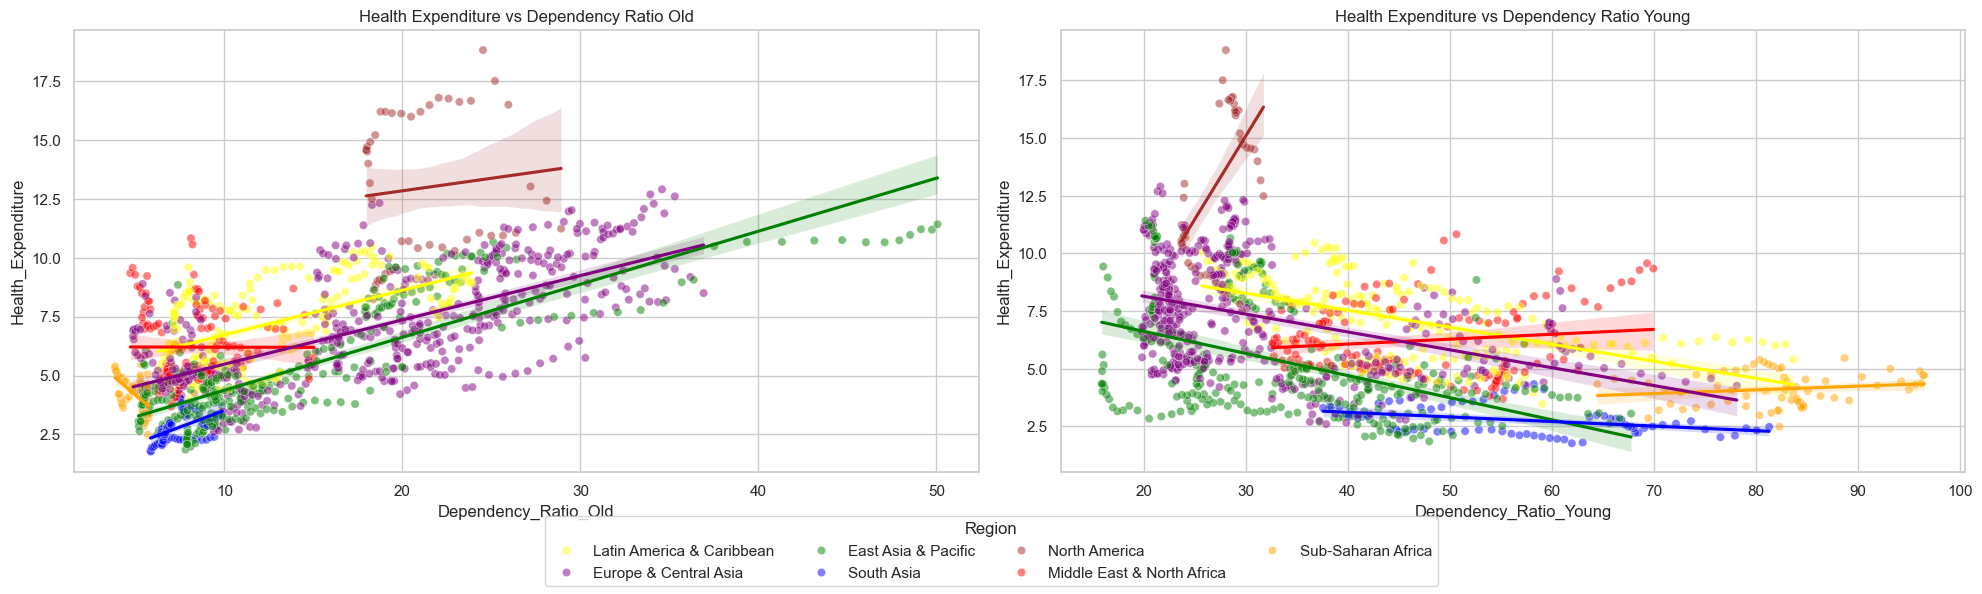

In [31]:
# Define custom color palette
palette = {
    "Latin America & Caribbean": "yellow",
    "North America": "brown",
    "Sub-Saharan Africa": "orange",
    "Middle East & North Africa": "red",
    "Europe & Central Asia": "purple",
    "East Asia & Pacific": "green",
    "South Asia": "blue",
}

# Set up the plot style
#sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Health Expenditure vs Dependency_Ratio_Old
sns.scatterplot(data=df, x="Dependency_Ratio_Old", y="Health_Expenditure", hue="Region", palette=palette, alpha=0.5, ax=axes[0])
for Region, color in palette.items():
    sub_df = df[df["Region"] == Region]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Old", y="Health_Expenditure", scatter=False, color=color, ax=axes[0])
axes[0].set_title("Health Expenditure vs Dependency Ratio Old")

# Plot 2: Health Expenditure vs Dependency_Ratio_Young
sns.scatterplot(data=df, x="Dependency_Ratio_Young", y="Health_Expenditure", hue="Region", palette=palette, alpha=0.5, ax=axes[1])
for Region, color in palette.items():
    sub_df = df[df["Region"] == Region]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Young", y="Health_Expenditure", scatter=False, color=color, ax=axes[1])
axes[1].set_title("Health Expenditure vs Dependency Ratio Young")

# Adjust legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Region", loc='lower center', ncol=4)
for ax in axes:
    ax.legend_.remove()

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.subplots_adjust(bottom=0.2)
plt.show()

The left graph illustrates a generally positive relationship between old-age dependency ratio and health expenditure (% of GDP) across most world regions. In particular, North America and Europe & Central Asia exhibit a strong upward trend, reflecting how aging populations in these regions place growing demands on healthcare systems. Meanwhile, East Asia & Pacific and South Asia show a weaker or flatter slope, suggesting a more gradual fiscal response to aging. Despite regional diversity, the overall pattern underscores that higher old-age dependency is often accompanied by greater health spending, especially in more developed areas.

In contrast, the right graph—plotting health expenditure against young-age dependency ratio—reveals a predominantly negative or inconsistent pattern across regions. Most regional trend lines (e.g., Europe & Central Asia, East Asia & Pacific, and South Asia) slope downward, indicating that countries with a larger share of young dependents tend to spend less on healthcare. This could be due to lower immediate healthcare needs among younger populations. However, North America stands out with a sharply positive slope, likely driven by outliers or unique healthcare dynamics. Overall, the regional variation reflects that the fiscal pressure of youth dependency is less direct and more context-dependent compared to aging populations.

#### Education Expenditure vs Dependency Ratio

###### **Figure 8. Education Expenditure and Dependency Ratio (Old and Young) By Income**

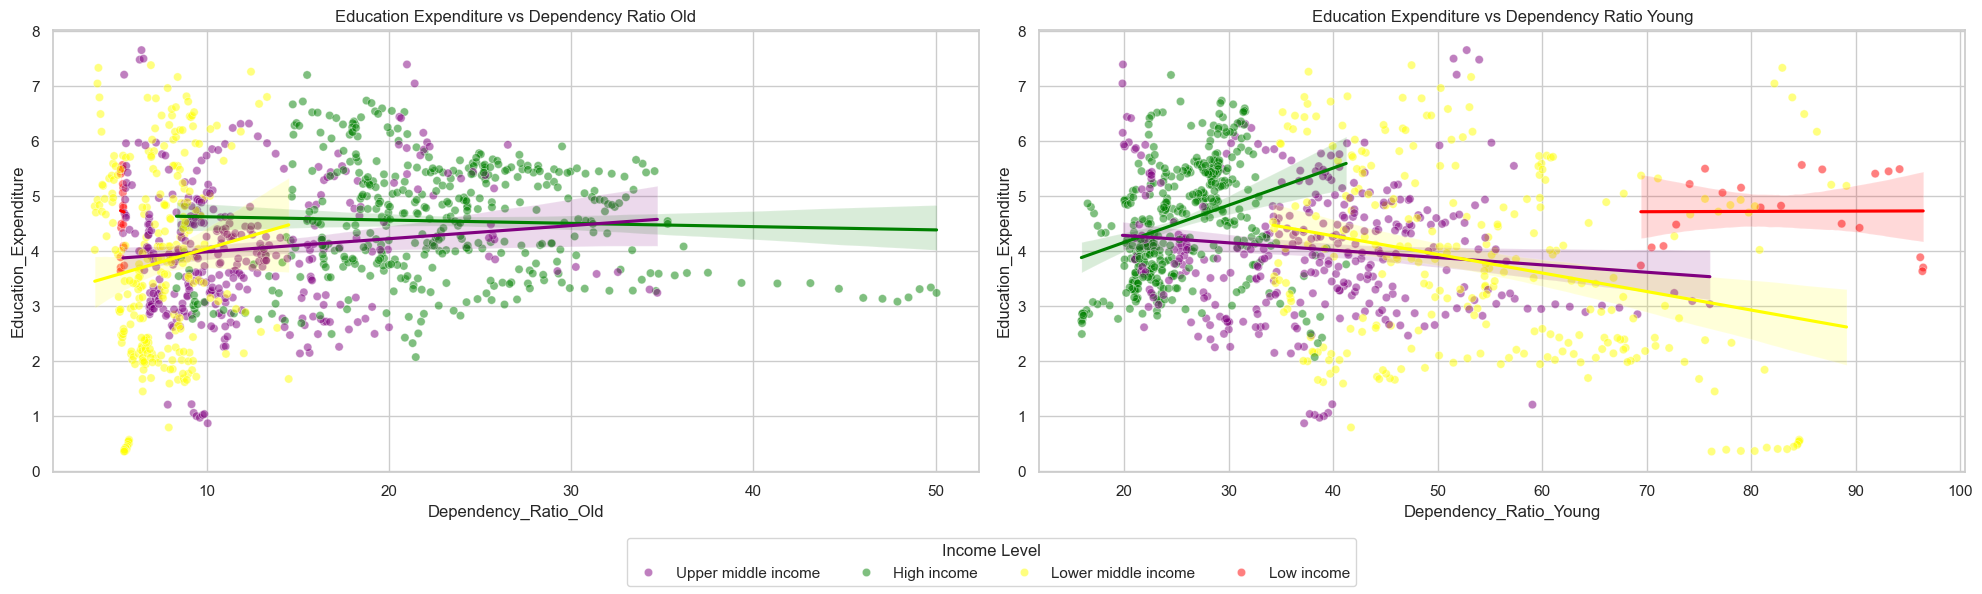

In [32]:
# Define custom color palette
palette = {
    "High income": "green",
    "Upper middle income": "purple",
    "Lower middle income": "yellow",
    "Low income": "red"
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Education Expenditure vs Dependency_Ratio_Old
sns.scatterplot(data=df, x="Dependency_Ratio_Old", y="Education_Expenditure", hue="income_level", palette=palette, alpha=0.5, ax=axes[0])
for income, color in palette.items():
    sub_df = df[df["income_level"] == income]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Old", y="Education_Expenditure", scatter=False, color=color, ax=axes[0])
axes[0].set_title("Education Expenditure vs Dependency Ratio Old")

# Plot 2: Education Expenditure vs Dependency_Ratio_Young
sns.scatterplot(data=df, x="Dependency_Ratio_Young", y="Education_Expenditure", hue="income_level", palette=palette, alpha=0.5, ax=axes[1])
for income, color in palette.items():
    sub_df = df[df["income_level"] == income]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Young", y="Education_Expenditure", scatter=False, color=color, ax=axes[1])
axes[1].set_title("Education Expenditure vs Dependency Ratio Young")

# Adjust legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Income Level", loc='lower center', ncol=4)
for ax in axes:
    ax.legend_.remove()

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.subplots_adjust(bottom=0.2)
plt.show()

How about education expenditure? In the left graph (old-age dependency), most trend lines are nearly flat, suggesting that increasing elderly populations don’t significantly affect how much countries spend on education. On the right (young-age dependency), there's slightly more variation, but the trends are mixed across income levels — some decline (e.g. lower-middle income), others rise or stay flat. Overall, these plots imply that education spending is likely influenced more by policy priorities and economic capacity than by dependency ratios alone.

###### **Figure 9. Health Expenditure and Dependency Ratio (Old and Young) By Region**

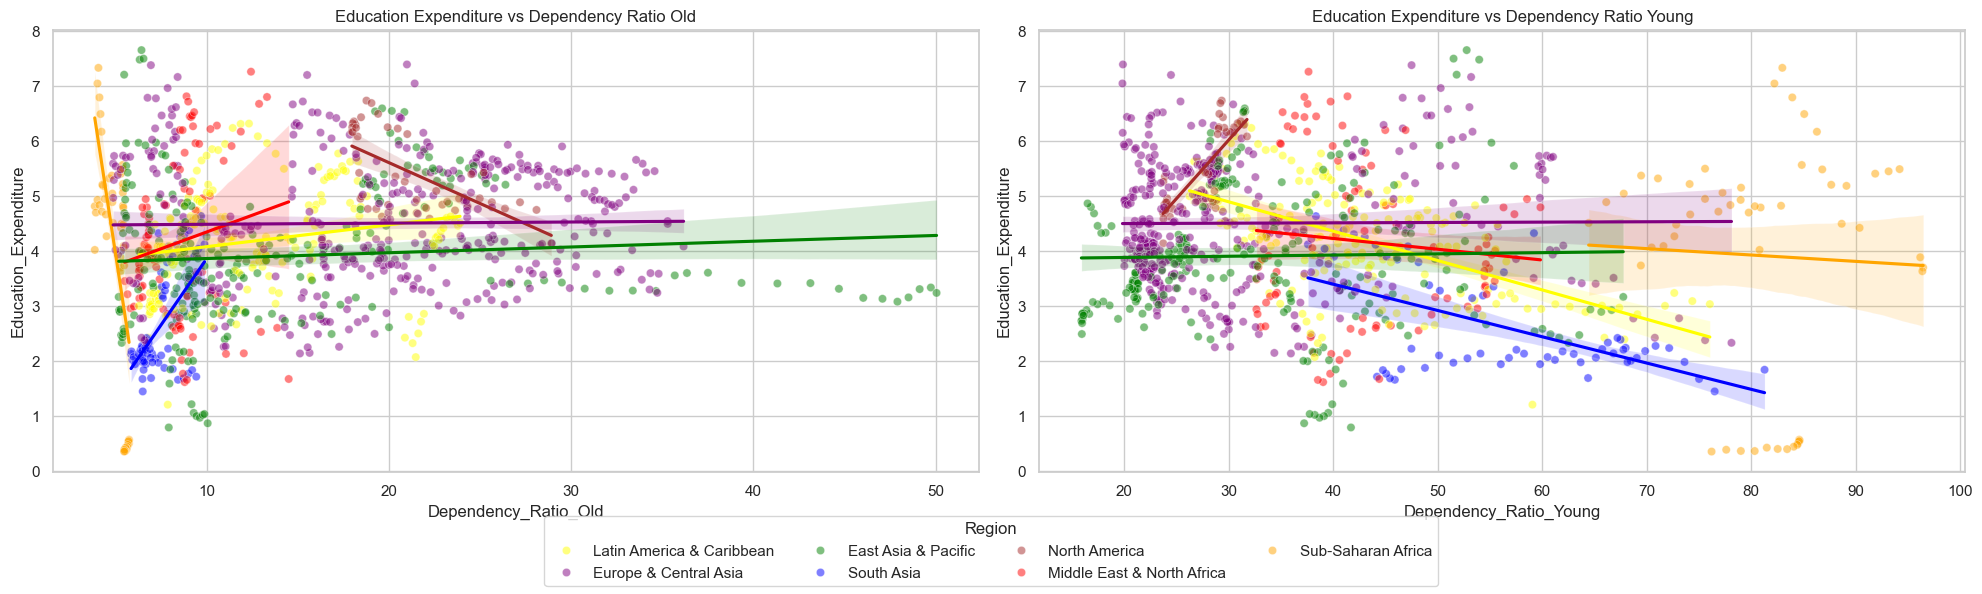

In [33]:
# Define custom color palette
palette = {
    "Latin America & Caribbean": "yellow",
    "North America": "brown",
    "Sub-Saharan Africa": "orange",
    "Middle East & North Africa": "red",
    "Europe & Central Asia": "purple",
    "East Asia & Pacific": "green",
    "South Asia": "blue",
}

# Set up the plot style
#sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Education Expenditure vs Dependency_Ratio_Old
sns.scatterplot(data=df, x="Dependency_Ratio_Old", y="Education_Expenditure", hue="Region", palette=palette, alpha=0.5, ax=axes[0])
for Region, color in palette.items():
    sub_df = df[df["Region"] == Region]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Old", y="Education_Expenditure", scatter=False, color=color, ax=axes[0])
axes[0].set_title("Education Expenditure vs Dependency Ratio Old")

# Plot 2: Education Expenditure vs Dependency_Ratio_Young
sns.scatterplot(data=df, x="Dependency_Ratio_Young", y="Education_Expenditure", hue="Region", palette=palette, alpha=0.5, ax=axes[1])
for Region, color in palette.items():
    sub_df = df[df["Region"] == Region]
    sns.regplot(data=sub_df, x="Dependency_Ratio_Young", y="Education_Expenditure", scatter=False, color=color, ax=axes[1])
axes[1].set_title("Education Expenditure vs Dependency Ratio Young")

# Adjust legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Region", loc='lower center', ncol=4)
for ax in axes:
    ax.legend_.remove()

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.subplots_adjust(bottom=0.2)
plt.show()

How about education expenditure? In the left graph (old-age dependency), most regional trend lines are relatively flat, suggesting that rising elderly populations don’t strongly influence how much countries spend on education. While a few regions—like Latin America & the Caribbean or Europe & Central Asia—show slight upward trends, others like North America slope downward, and some remain neutral. This indicates that education budgets are generally insulated from demographic aging.

On the right graph (young-age dependency), there’s a bit more variation, but again, the patterns differ by region. For instance, East Asia & Pacific and South Asia show declining education expenditure as young dependency rises, while Latin America & the Caribbean stays relatively steady. Sub-Saharan Africa and North America exhibit flatter or more uncertain trends. Altogether, these plots suggest that regional education spending is shaped more by national policy priorities and fiscal space than by dependency ratios alone.

### Regression Analysis

#### Dependent Variable: Health Expenditure

In [34]:
# Preparing The Data for Modeling (Health Expenditure dependent variable)
df = pd.read_csv("../data/interim/merged_data.csv")

# Create log of GDP per capita, Covid dummies, and lag dependency ratio old
df["log_GDP_percapita"] = np.log(df["GDP_percapita"])
df['D_2020'] = (df['Year'] == 2020).astype(int)
df['D_2021'] = (df['Year'] == 2021).astype(int)
df['DepOld_lag1'] = (
    df.groupby('ISO3')['Dependency_Ratio_Old']
            .shift(1)
)

# Filter data to 2000–2022 and drop missing values
df_model = df[
    (df["Year"] <= 2022) &
    df["Health_Expenditure"].notna() &
    df["Dependency_Ratio_Old"].notna() &
    df["Dependency_Ratio_Young"].notna() &
    df["log_GDP_percapita"].notna() &
    df["trade_gdp"].notna() &
    df["D_2020"].notna() &
    df["D_2021"].notna() &
    df["DepOld_lag1"].notna()
].copy()

# Replace spaces in country names
df_model["Country"] = df_model["Country"].str.replace(" ", "_")


##### Pooled OLS

In [35]:
# 1) Pooled OLS
formula_ols = (
    'Health_Expenditure ~ '
    'Dependency_Ratio_Old +  '
    'log_GDP_percapita + trade_gdp'
)

pooled_ols = smf.ols(formula_ols, data=df_model).fit()
print("=== Model 1: Pooled OLS ===")
print(pooled_ols.summary())

=== Model 1: Pooled OLS ===
                            OLS Regression Results                            
Dep. Variable:     Health_Expenditure   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     388.9
Date:                Tue, 24 Jun 2025   Prob (F-statistic):          2.28e-174
Time:                        18:04:02   Log-Likelihood:                -2408.4
No. Observations:                1155   AIC:                             4825.
Df Residuals:                    1151   BIC:                             4845.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Inte

##### Country FE

In [36]:
# 2) Country FE
formula_fe_country = (
    'Health_Expenditure ~ '
    'Dependency_Ratio_Old + '
    'log_GDP_percapita + trade_gdp + '
    'C(ISO3)'
)

fe_country = smf.ols(formula_fe_country, data=df_model).fit()
print("\n=== Model 2: Country FE ===")
print(fe_country.summary())


=== Model 2: Country FE ===
                            OLS Regression Results                            
Dep. Variable:     Health_Expenditure   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     244.9
Date:                Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                        18:04:16   Log-Likelihood:                -1320.0
No. Observations:                1155   AIC:                             2752.
Df Residuals:                    1099   BIC:                             3035.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Int

##### Country and Covid FE

In [37]:
# 3) TWFE with only Country FE + two year dummies, default (non‐clustered) SE
formula_covid = (
    'Health_Expenditure ~ '
    'Dependency_Ratio_Old + '
    'log_GDP_percapita + trade_gdp + '
    'C(ISO3) + D_2020 + D_2021'
)

twfe_covid_plain = smf.ols(formula_covid, data=df_model).fit()

print("=== TWFE controlling only 2020 & 2021, non‐clustered SE ===")
print(twfe_covid_plain.summary())

=== TWFE controlling only 2020 & 2021, non‐clustered SE ===
                            OLS Regression Results                            
Dep. Variable:     Health_Expenditure   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     241.9
Date:                Tue, 24 Jun 2025   Prob (F-statistic):               0.00
Time:                        18:04:21   Log-Likelihood:                -1306.5
No. Observations:                1155   AIC:                             2729.
Df Residuals:                    1097   BIC:                             3022.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

##### Country and Covid FE (Clustered)

In [38]:
# 4) TWFE with only Country FE + two year dummies, clustered SE
formula_covid = (
    'Health_Expenditure ~ '
    'Dependency_Ratio_Old + '
    'log_GDP_percapita + trade_gdp +'
    'C(ISO3) + D_2020 + D_2021'
)

twfe_covid_cluster = smf.ols(formula_covid, data=df_model).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_model['ISO3'].values}
)

print(twfe_covid_cluster.summary())

                            OLS Regression Results                            
Dep. Variable:     Health_Expenditure   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     23.82
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           2.26e-12
Time:                        18:04:26   Log-Likelihood:                -1306.5
No. Observations:                1155   AIC:                             2729.
Df Residuals:                    1097   BIC:                             3022.
Df Model:                          57                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.3776 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 57, but rank is 5
  warnings.warn('covariance of constraints does not have full '


##### Lag Model

In [39]:
# 5) Estimate TWFE + COVID dummies + 1‐year lag
formula_lag1 = (
    'Health_Expenditure ~ '
    'Dependency_Ratio_Old + DepOld_lag1 + '
    'log_GDP_percapita + trade_gdp +'
    'C(ISO3) + D_2020 + D_2021'
)

twfe_lag1 = smf.ols(formula_lag1, data=df_model).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_model['ISO3'].values}
)
print(twfe_lag1.summary())

                            OLS Regression Results                            
Dep. Variable:     Health_Expenditure   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     59.84
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           1.32e-21
Time:                        18:04:31   Log-Likelihood:                -1298.9
No. Observations:                1155   AIC:                             2716.
Df Residuals:                    1096   BIC:                             3014.
Df Model:                          58                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.8692 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 58, but rank is 6
  warnings.warn('covariance of constraints does not have full '


##### Regression Summary

###### **Table 5. Regression of Health Expenditure on Old-Age Dependency Ratio (Summary)**

In [41]:
from statsmodels.iolib.summary2 import summary_col
# 1) collect fitted models
models = [pooled_ols, fe_country, twfe_covid_plain, twfe_covid_cluster, twfe_lag1]

# 2) the column headers
model_names = ["Pooled OLS", "Country FE", "Country & Covid FE", "Country & Covid FE (clustered)", "Lag"]

# 3) regressor order
regressor_order = [
    "Dependency_Ratio_Old", "DepOld_lag1", "log_GDP_percapita", "trade_gdp"]

# 4) additional stats
info_dict = {
    "Observations": lambda m: f"{int(m.nobs):,}",
    "R-squared":     lambda m: f"{m.rsquared:.3f}",
}

# 5) create the summary
summary = summary_col(
    results=models,
    model_names=model_names,
    regressor_order=regressor_order,
    info_dict=info_dict,
    stars=True,            # adds *,**,***
    drop_omitted=True,
    float_format="%0.3f"
)

# 6) pull out the DataFrame and rename the rows/variables
df = summary.tables[0]

df = df.rename(index={
    "Dependency_Ratio_Old":       "Dependency Ratio (Old)",
    "DepOld_lag1":                "Lagged Dependency Ratio (Old)",
    "log_GDP_percapita":          "Log GDP per capita",
    "trade_gdp":                  "Trade-to-GDP"
})

# 7) append FE indicators
df.loc["Country FE"] = ["No","Yes","Yes","Yes","Yes"]
df.loc["Covid FE"]   = ["No","No","Yes","Yes","Yes"]

# 8) display
print(df)
df.to_csv("../overleaf/Tabel 5 Regression Health Expenditure.csv")

                              Pooled OLS Country FE Country & Covid FE  \
Dependency Ratio (Old)          0.118***   0.180***           0.157***   
                                 (0.010)    (0.011)            (0.012)   
Lagged Dependency Ratio (Old)                                            
                                                                         
Log GDP per capita              0.792***   0.359***           0.342***   
                                 (0.062)    (0.057)            (0.056)   
Trade-to-GDP                   -0.010***   -0.003**             -0.002   
                                 (0.001)    (0.002)            (0.002)   
R-squared                          0.503      0.925              0.926   
R-squared Adj.                     0.502      0.921              0.922   
Observations                       1,155      1,155              1,155   
R-squared                          0.503      0.925              0.926   
Country FE                            

Table 5 reports the summary of all regressions estimating the effect of the old‐age dependency ratio on health spending as a share of GDP. Column (1) presents a simple pooled regression, Columns (2) and (3) add country and two‐way (country + covid year) fixed effects, Column (4) repeats the two‐way FE model with standard errors clustered by country, and Column (5) augments the clustered FE model with a one‐year lag of the dependency ratio. All regressions control for log GDP per capita and trade openness.

In our view, column 4 (“Country & Covid FE (clustered)”) is the cleanest baseline: it includes both country and covid fixed effects, and its standard errors are clustered by country to allow for within‐country serial correlation.

$$
\text{HealthExp}_{it} = \beta_1 \cdot \text{DepOld}_{it} + \beta_2 \cdot \text{LnGDPpc}_{it} + \beta_3 \cdot \text{TradeGDP}_{it} + \mu_i + \lambda_{2020} + \lambda_{2021} + \varepsilon_{it}
$$

- $\beta_0$: constant term  
- $\beta_1$: effect of aging   
- $\beta_2$: effect of LnGDP per capita  
- $\beta_3$: effect of trade openness (trade as % of GDP)  
- $\mu_i$: country fixed effect  
- $\lambda$: covid year fixed effect 
- $\epsilon_{it}$: error term for country $i$ in year $t$


Effect of old‐age dependency.
Across specifications, the coefficient on the old‐age dependency ratio is positive and highly significant which in our main specification is at **0.157** (SE = 0.026). That means a 1 pp rise in the aging ratio is associated with a 0.157 pp increase in health spending as a share of GDP, holding other variable constant. Its magnitude and significance are only slightly attenuated when we move from Pooled OLS → Country FE → two‐way FE, which speaks to the robustness of this demographic effect.

Controls and fit.
Log GDP pc retains a strong positive association (≈ 0.337 **, SE = 0.054) in the clustered‐SE model, implying wealthier countries spend more on health. Trade‐to‐GDP turns slightly negative (≈ – 0.002) and is no longer significant once we soak up fixed effects and clustering, suggesting openness matters less for health budgets once you control for demographics and income. 

Lagged adjustment.
Column 5 adds a one-year lag of the old‐age dependency ratio and tells a classic partial‐adjustment story. The coefficient jumps to 0.558 (SE = 0.216), while the lag is – 0.416 (SE = 0.221). In other words, health spending overshoots when the demographic shock hits (year t) and then “gives back” a portion in year t+1. This dynamic suggests policymakers front‐load their budget response to aging but then adjust downward as the new dependency structure becomes permanent.

#### Dependent Variable: Education Expenditure

In [42]:
# Preparing The Data for Modeling (Education Expenditure dependent variable)
df = pd.read_csv("../data/interim/merged_data.csv")

# Create log of GDP per capita, Covid dummies, and lag dependency ratio old
df["log_GDP_percapita"] = np.log(df["GDP_percapita"])
df['D_2020'] = (df['Year'] == 2020).astype(int)
df['D_2021'] = (df['Year'] == 2021).astype(int)
df['DepYoung_lag1'] = (
    df.groupby('ISO3')['Dependency_Ratio_Young']
            .shift(1)
)

# Filter data to 2000–2022 and drop missing values
df_model_edu = df[
    (df["Year"] <= 2022) &
    df["Education_Expenditure"].notna() &
    df["Dependency_Ratio"].notna() &
    df["Dependency_Ratio_Old"].notna() &
    df["Dependency_Ratio_Young"].notna() &
    df["log_GDP_percapita"].notna() &
    df["trade_gdp"].notna() &
    df["D_2020"].notna() &
    df["D_2021"].notna() &
    df["DepYoung_lag1"].notna()
].copy()

# Replace spaces in country names
df_model_edu["Country"] = df_model_edu["Country"].str.replace(" ", "_")

##### Pooled OLS

In [43]:
# 1) Pooled OLS
formula_ols_edu = (
    'Education_Expenditure ~ '
    'Dependency_Ratio_Young +  '
    'log_GDP_percapita + trade_gdp'
)

pooled_ols_edu = smf.ols(formula_ols_edu, data=df_model_edu).fit()
print("=== Model 1: Pooled OLS ===")
print(pooled_ols_edu.summary())

=== Model 1: Pooled OLS ===
                              OLS Regression Results                             
Dep. Variable:     Education_Expenditure   R-squared:                       0.071
Model:                               OLS   Adj. R-squared:                  0.069
Method:                    Least Squares   F-statistic:                     25.09
Date:                   Tue, 24 Jun 2025   Prob (F-statistic):           1.20e-15
Time:                           18:07:05   Log-Likelihood:                -1572.4
No. Observations:                    983   AIC:                             3153.
Df Residuals:                        979   BIC:                             3172.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

##### Country FE

In [44]:
# 2) Country FE
formula_fe_country_edu = (
    'Education_Expenditure ~ '
    'Dependency_Ratio_Young + '
    'log_GDP_percapita + trade_gdp + '
    'C(ISO3)'
)

fe_country_edu = smf.ols(formula_fe_country_edu, data=df_model_edu).fit()
print("\n=== Model 2: Country FE ===")
print(fe_country_edu.summary())


=== Model 2: Country FE ===
                              OLS Regression Results                             
Dep. Variable:     Education_Expenditure   R-squared:                       0.774
Model:                               OLS   Adj. R-squared:                  0.760
Method:                    Least Squares   F-statistic:                     57.66
Date:                   Tue, 24 Jun 2025   Prob (F-statistic):          3.26e-259
Time:                           18:07:08   Log-Likelihood:                -878.21
No. Observations:                    983   AIC:                             1868.
Df Residuals:                        927   BIC:                             2142.
Df Model:                             55                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

##### Country and Covid FE

In [45]:
# 3) TWFE with only Country FE + two year dummies, default (non‐clustered) SE
formula_covid_edu = (
    'Education_Expenditure ~ '
    'Dependency_Ratio_Young + '
    'log_GDP_percapita + trade_gdp + '
    'C(ISO3) + D_2020 + D_2021'
)

twfe_covid_plain_edu = smf.ols(formula_covid_edu, data=df_model_edu).fit()

print("=== TWFE controlling only 2020 & 2021, non‐clustered SE ===")
print(twfe_covid_plain_edu.summary())

=== TWFE controlling only 2020 & 2021, non‐clustered SE ===
                              OLS Regression Results                             
Dep. Variable:     Education_Expenditure   R-squared:                       0.774
Model:                               OLS   Adj. R-squared:                  0.760
Method:                    Least Squares   F-statistic:                     55.68
Date:                   Tue, 24 Jun 2025   Prob (F-statistic):          6.72e-258
Time:                           18:07:11   Log-Likelihood:                -877.10
No. Observations:                    983   AIC:                             1870.
Df Residuals:                        925   BIC:                             2154.
Df Model:                             57                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

##### Country and Covid FE (Clustered)

In [46]:
# 4) TWFE with only Country FE + two year dummies, clustered SE
formula_covid_edu = (
    'Education_Expenditure ~ '
    'Dependency_Ratio_Young + '
    'log_GDP_percapita + trade_gdp +'
    'C(ISO3) + D_2020 + D_2021'
)

twfe_covid_cluster_edu = smf.ols(formula_covid_edu, data=df_model_edu).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_model_edu['ISO3'].values}
)

print(twfe_covid_cluster_edu.summary())

                              OLS Regression Results                             
Dep. Variable:     Education_Expenditure   R-squared:                       0.774
Model:                               OLS   Adj. R-squared:                  0.760
Method:                    Least Squares   F-statistic:                     1.079
Date:                   Tue, 24 Jun 2025   Prob (F-statistic):              0.383
Time:                           18:07:19   Log-Likelihood:                -877.10
No. Observations:                    983   AIC:                             1870.
Df Residuals:                        925   BIC:                             2154.
Df Model:                             57                                         
Covariance Type:                 cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 57, but rank is 5
  warnings.warn('covariance of constraints does not have full '


##### Regression Summary

###### **Table 6. Regression of Education Expenditure on Young-Age Dependency Ratio (Summary)**

In [48]:
from statsmodels.iolib.summary2 import summary_col
# 1) collect fitted models
models = [pooled_ols_edu, fe_country_edu, twfe_covid_plain_edu, twfe_covid_cluster_edu]

# 2) the column headers
model_names = ["Pooled OLS", "Country FE", "Country & Covid FE", "Country & Covid FE (clustered)"]

# 3) regressor order
regressor_order = [
    "Dependency_Ratio_Young", "log_GDP_percapita", "trade_gdp"]

# 4) additional stats
info_dict = {
    "Observations": lambda m: f"{int(m.nobs):,}",
    "R-squared":     lambda m: f"{m.rsquared:.3f}",
}

# 5) create the summary
summary = summary_col(
    results=models,
    model_names=model_names,
    regressor_order=regressor_order,
    info_dict=info_dict,
    stars=True,            # adds *,**,***
    drop_omitted=True,
    float_format="%0.3f"
)

# 6) pull out the DataFrame and rename the rows/variables
df = summary.tables[0]

df = df.rename(index={
    "Dependency_Ratio_Young":       "Dependency Ratio (Young)",
    "log_GDP_percapita":          "Log GDP per capita",
    "trade_gdp":                  "Trade-to-GDP"
})

# 7) append FE indicators
df.loc["Country FE"] = ["No","Yes","Yes","Yes"]
df.loc["Covid FE"]   = ["No","No","Yes","Yes"]

# 8) display
print(df)
df.to_csv("../overleaf/Tabel 6 Regression Education Expenditure.csv")

                         Pooled OLS Country FE Country & Covid FE  \
Dependency Ratio (Young)    0.008**      0.006              0.006   
                            (0.004)    (0.007)            (0.007)   
Log GDP per capita         0.302***   0.234***           0.241***   
                            (0.042)    (0.060)            (0.060)   
Trade-to-GDP                -0.001*   -0.003**           -0.003**   
                            (0.001)    (0.001)            (0.001)   
R-squared                     0.071      0.774              0.774   
R-squared Adj.                0.069      0.760              0.760   
Observations                    983        983                983   
R-squared                     0.071      0.774              0.774   
Country FE                       No        Yes                Yes   
Covid FE                         No         No                Yes   

                         Country & Covid FE (clustered)  
Dependency Ratio (Young)                    

In the simple pooled OLS (Column 1), we observe a small but significant positive association between the young‐age dependency ratio and education spending. However, once we add country fixed effects in Column 2 and then year dummies in Column 3, the point estimate shrinks slightly to around 0.006 and is no longer distinguishable from zero. In our preferred two‐way FE model with clustered standard errors (Column 4), the coefficient remains 0.006 but with SE = 0.020 (p > 0.1), indicating no robust relationship. 

This pattern suggests that, unlike health expenditure, education budgets may be far less responsive to year-to-year shifts in the number of young age population. Instead, education spending appears driven more by long-run fiscal frameworks, rather than short‐term demographic fluctuations.

## 5. Health Expenditure Projections (to 2050)

### GDP per capita and Trade Openess projection using log-linear regression

In [49]:
#Call the function for preparing the data for GDP and trade projection
sys.path.append("../src/projection_data")
from projection_data import project_gdp_and_trade

df_projected = project_gdp_and_trade()
df_projected.to_csv('../data/interim/merged_data_projected.csv', index=False)

###### **Figure 10. GDP per Capita Projection by Country**

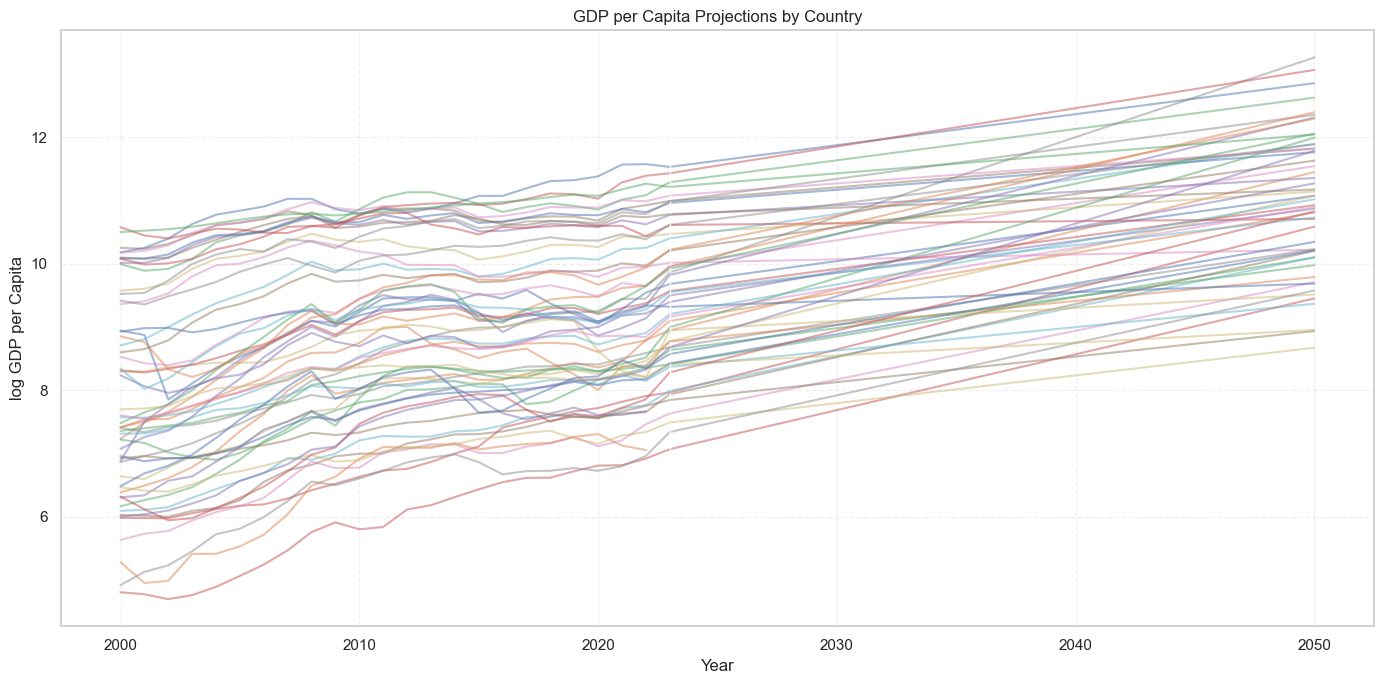

In [50]:
# Plot
plt.figure(figsize=(14, 7))

for iso, group in df_projected.groupby("ISO3"):
    plt.plot(group["Year"], group["log_GDP_percapita"], alpha=0.5)  # light lines

# Add vertical line to mark the start of projection (2024)
plt.axvline(x=2023, color='white', linestyle='--', linewidth=1)
plt.text(2024.5, plt.ylim()[1]*0.95, 'Start of Projection', color='white')

plt.title("GDP per Capita Projections by Country")
plt.xlabel("Year")
plt.ylabel("log GDP per Capita")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Health Expenditure Projection

Using the TWFE model with country fixed effects and clustered SEs:

$$
\widehat{\mathrm{HealthExp}}_{it}
=3.4107
\;+\;0.1582\,\mathrm{DepOld}_{it}
\;+\;0.3371\,\ln(\mathrm{GDPpc}_{it})
\;-\;0.0022\,\mathrm{TradeGDP}_{it}
\;+\;\mu_i
$$

where $ \mu_i $ are country fixed effects.  


In [51]:
#Preparing the data for health expenditure projection
import pandas as pd

def project_health_manual(df_projected, twfe_model):
    df = df_projected.copy()

    # 1) covid dummies
    df["D_2020"] = (df["Year"] == 2020).astype(int)
    df["D_2021"] = (df["Year"] == 2021).astype(int)

    # 2) future slice needing Health_Expenditure
    mask = (df["Year"] >= 2023) & df["Health_Expenditure"].isna()
    df_future = df.loc[mask].copy()

    # 3) create *all* ISO3 dummies (no drop_first!)
    iso_dummies = pd.get_dummies(
        df_future["ISO3"],
        prefix="C(ISO3)",
        drop_first=False
    )
    # rename C(ISO3)_AAA → C(ISO3)[T.AAA]
    iso_dummies.columns = [
        col.replace("C(ISO3)_", "C(ISO3)[T.") + "]"
        for col in iso_dummies.columns
    ]
    df_future = pd.concat([df_future, iso_dummies], axis=1)

    # 4) make sure every regressor the model expects exists:
    for exog in twfe_model.model.exog_names:
        if exog == "Intercept":
            df_future["Intercept"] = 1
        elif exog not in df_future.columns:
            df_future[exog] = 0

    # 5) dot-product forecast
    params = twfe_model.params
    X = df_future[params.index]
    df_future["Health_Expenditure"] = X.dot(params)

    # 6) merge back
    df_future["Health_Expenditure"] = df_future["Health_Expenditure"].astype(float)
    df.update(df_future[["Health_Expenditure"]])
    return df

# — run it —
df_projected = project_gdp_and_trade()
df_projected = project_health_manual(df_projected, twfe_covid_cluster)
df_projected.to_csv("../data/final/merged_data_health_projection.csv", index=False)

###### **Figure 11. Health Expenditure Projection by Country**

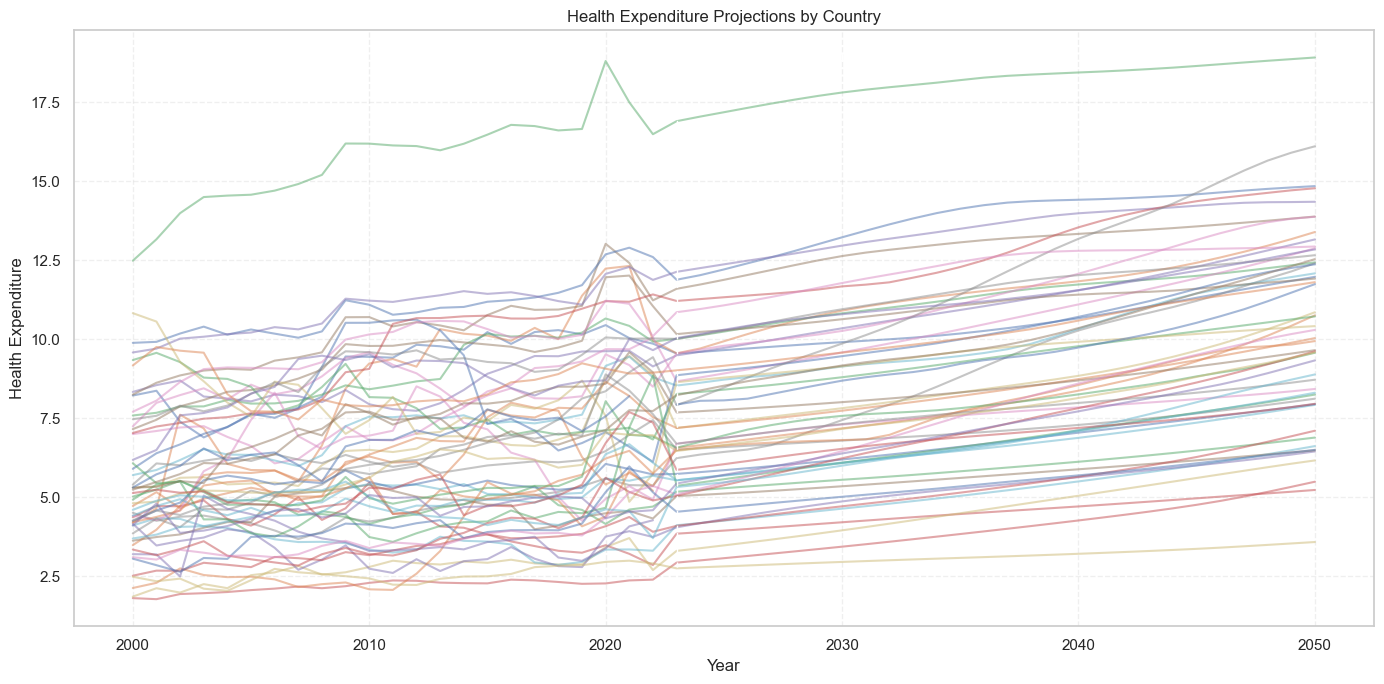

In [52]:
# Plot
plt.figure(figsize=(14, 7))

for iso, group in df_projected.groupby("ISO3"):
    plt.plot(group["Year"], group["Health_Expenditure"], alpha=0.5)  # light lines

# Add vertical line to mark the start of projection (2024)
plt.axvline(x=2023, color='white', linestyle='--', linewidth=1)
plt.text(2024.5, plt.ylim()[1]*0.95, 'Start of Projection', color='white')

plt.title("Health Expenditure Projections by Country")
plt.xlabel("Year")
plt.ylabel("Health Expenditure")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

We use our clustered two-way fixed-effects model (Country FE + COVID dummies, clustered SEs) to project Health Expenditure (% of GDP) out to 2050. The vertical dashed line marks the start of out-of-sample projections in 2023, while the shaded band highlights the COVID years (2020–21).

Prior to the pandemic, most countries exhibit relatively stable health shares clustered between roughly 5 % and 12 % of GDP, with the United States notably outlier at around 15 %–18 %. The COVID shock produces a one-off spike in spending—captured by our 2020–21 dummies—before the budget share settles back toward its long-run trend.

In [53]:
# Filter for the year 2050
df_2050 = df_projected[df_projected["Year"] == 2050].copy()

# Sort by Health_Expenditure descending and get top 10
top10 = df_2050.sort_values("Health_Expenditure", ascending=False).head(10)

# Display result
print(top10[["Country", "ISO3", "Health_Expenditure"]])

            Country ISO3  Health_Expenditure
2651  United States  USA               18.92
2294    South Korea  KOR               16.11
764         Germany  DEU               14.85
1121          Japan  JPN               14.78
713          France  FRA               14.36
305          Canada  CAN               13.89
815          Greece  GRC               13.88
101         Armenia  ARM               13.40
254          Brazil  BRA               13.16
1682    Netherlands  NLD               12.94


In [54]:
sys.path.append('../src/visualization')
from health_line import get_health_data, plot_health_lines

###### **Figure 12. Health Expenditure Projection for Selected Countries**

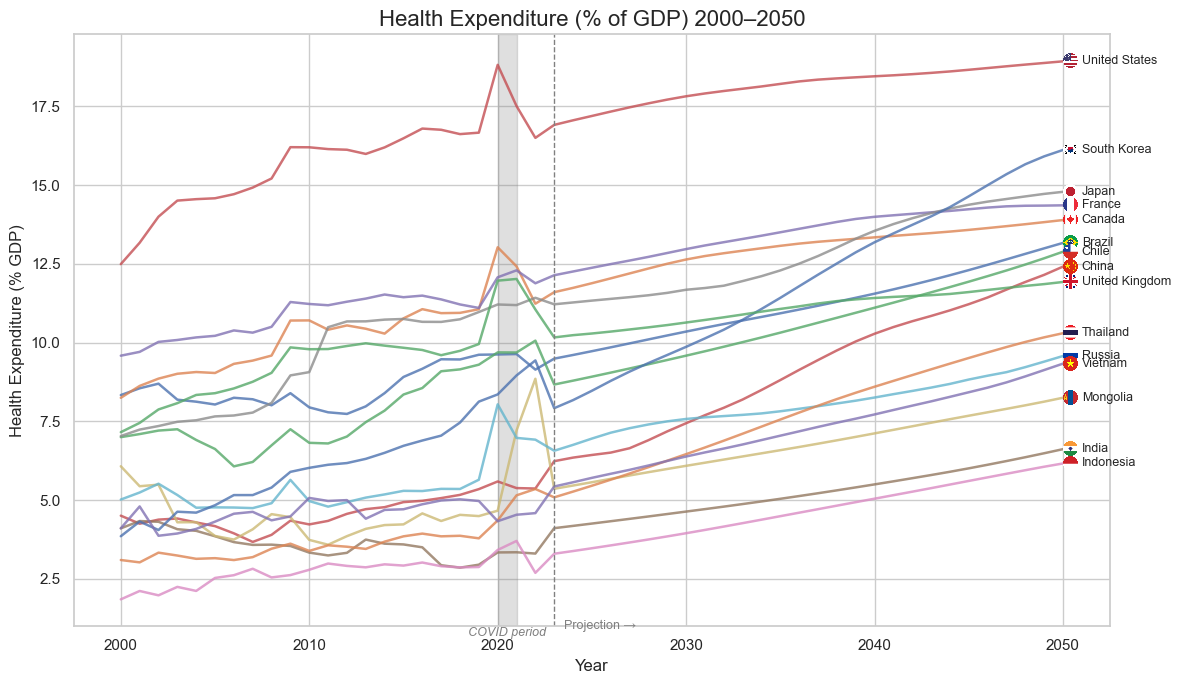

In [55]:
df_health = get_health_data()
plot_health_lines(df_health)

Looking at the post-2022 forecasts, the model predicts a gradual increase in health outlays across the board, driven mainly by rising old-age dependency and income effects. South Korea, in particular, shows one of the steepest projected upticks: having hovered near 8 % of GDP pre-2020, it climbs above 12 % by 2050. This pronounced rise reflects Korea’s rapidly aging population (one of the fastest-growing old-age dependency ratios in our sample) coupled with high income elasticity of health spending

## 6. Health Effeciency Index Analysis